# Overview
## GIVEN: A dataset of pairs of images and natural language captions.
## AIM: We want to build a tf.dataset where each instance consists of an image and a caption. However, we want the images to actually be feature extractions of a CNN and the captions to be tokenized integer sequences.

### For later use, we want to save our CNN, our Tokenizer, our Embedding Layer, and our train and validation tf.Datasets.

In [1]:
import tensorflow as tf
import json
from pathlib import Path

In [2]:
ANNOTATION_PATH = Path('../data/annotations/captions_train2014.json')
IMAGES_PATH = Path('../data/images/')

In [3]:
with open(ANNOTATION_PATH, 'r') as f:
    annotations = json.load(f)

In [4]:
annotations

{'info': {'description': 'COCO 2014 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2014,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'images': [{'license': 5,
   'file_name': 'COCO_train2014_000000057870.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-14 16:28:13',
   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
   'id': 57870},
  {'license': 5,
   'file_name': 'COCO_train2014_000000384029.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
   'height': 429,
   'width': 640,
   'date_captured': '2013-11-14 16:29:45',
   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
   'id': 384029},
  {'license': 1,
   'file_name': 'COCO_train2014_000000222016.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_tr

# Load image captions and image names into arrays

In [5]:
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = IMAGES_PATH / ('COCO_train2014_' + '%012d.jpg' % image_id)
    
    all_captions.append(caption)
    all_img_name_vector.append(full_coco_image_path)

In [6]:
all_img_name_vector

[WindowsPath('../data/images/COCO_train2014_000000318556.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000116100.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000318556.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000116100.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000379340.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000379340.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000318556.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000318556.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000134754.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000538480.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000476220.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000299675.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000032275.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000302443.jpg'),
 WindowsPath('../data/images/COCO_train2014_000000134754.jpg'),
 WindowsPath('../data/images/COCO_train2

# Check filepaths are correct by displaying images

Shape: (480, 640, 3)
Shape: (640, 543, 3)
Shape: (640, 426, 3)


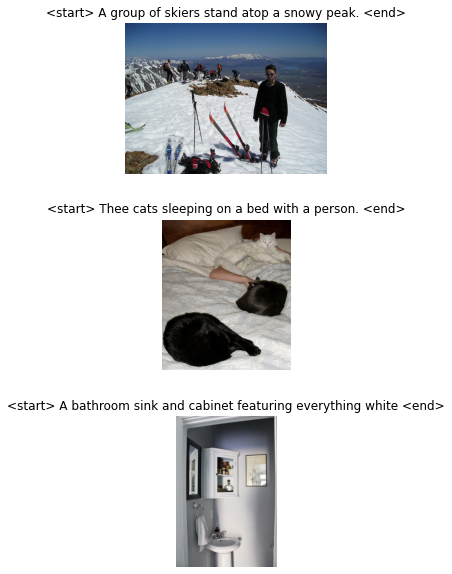

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_image(index):
    image = Image.open(all_img_name_vector[index])
    image = np.asarray(image)

    print('Shape:', image.shape)
    plt.imshow(image)
    plt.title(all_captions[index])
    plt.axis('off')
    
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
plt.subplot(3,1,1)
display_image(100)
plt.subplot(3,1,2)
display_image(101)
plt.subplot(3,1,3)
display_image(102)

In [8]:
len(all_captions), len(all_img_name_vector)

(414113, 414113)

In [9]:
cnn = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# InceptionV3 outputs tensors of shape 8x8x2048. To reduce complexity, we max pool one last time to have tensors of shape 4x4x2048.

In [10]:
input_layer = tf.keras.layers.Input(shape=[299, 299, 3])
cnn_output = cnn(input_layer)
outputs = tf.keras.layers.MaxPool2D()(cnn_output)

feature_extractor = tf.keras.models.Model(input_layer, outputs)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

feature_extractor.summary()

image, _ = load_image(str(all_img_name_vector[10]))
image = tf.expand_dims(image, 0)

output = feature_extractor(image)
output.shape

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 2048)        0         
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


TensorShape([1, 4, 4, 2048])

In [ ]:
feature_extractor.save('Model Component Save Files/cnn_feature_extractor')

# We will preprocess each image to its cnn features and then save each cnn representation as a numpy array with the same name. We do this so that we can later load image representations on demand inside a tf.Dataset.

In [41]:
from tqdm import tqdm

# Get unique images
unique_image_names = [str(path) for path in all_img_name_vector]
unique_image_names = sorted(set(unique_image_names))

image_dataset = tf.data.Dataset.from_tensor_slices(unique_image_names)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Unroll the spatial 4x4 dimension of the image to a single 16-size dimension
for imgs, paths in tqdm(image_dataset):
    batch_features = feature_extractor(imgs)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], 16, batch_features.shape[3]))
    
    for image_features, image_path in zip(batch_features, paths):
        path_of_feature = image_path.numpy().decode("utf-8")
        np.save(path_of_feature, image_features.numpy())

5174it [3:19:14,  2.31s/it]


# Next, before we can create our dataset with image representations and captions, we need to setup our text tokenizer and word embeddings.

#### Create Word Tokenizer

In [14]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

word_index = tokenizer.word_index
index_word = tokenizer.index_word

caption_token_sequences = tokenizer.texts_to_sequences(all_captions)
caption_token_sequences = tf.keras.preprocessing.sequence.pad_sequences(caption_token_sequences, padding='post')

In [15]:
caption_token_sequences.shape

(414113, 52)

In [63]:
MAX_CAPTION_LENGTH = max(len(c) for c in caption_token_sequences)
print(MAX_CAPTION_LENGTH)

52


In [45]:
len(word_index), len(index_word)

(24008, 24008)

In [41]:
caption_token_sequences[0].dtype

dtype('int32')

#### Create the Embedding Layer by loading a pretrained GLoVe embedding matrix

In [11]:
import os
import numpy as np

f = open("glove.6B.300d.txt", encoding="utf8")

embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.asarray(values[1:], dtype='float32')
    
    embeddings_index[word] = word_embedding
    
f.close()

len(embeddings_index)

400000

In [50]:
EMBEDDING_DIMENSIONS = 300
embedding_matrix = np.zeros((top_k, EMBEDDING_DIMENSIONS), dtype='float32')

for i in range(top_k):
    word = index_word[i]
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

In [52]:
embedding_matrix.shape

(5000, 300)

In [64]:
embedding_layer = tf.keras.layers.Embedding(input_dim=top_k, output_dim=EMBEDDING_DIMENSIONS, 
                                            weights=[embedding_matrix], input_length=MAX_CAPTION_LENGTH,
                                            trainable=False)

# Above we have created our Tokenizer, which contains the mapping between words and ids. We have also initialized our Embeddings. Now we just need to save both of these objects for later use.

In [69]:
test_sentence = ["<start> Hi my name is Raivo <end>"]
test_sequence = tokenizer.texts_to_sequences(test_sentence)

test_sequence = tf.constant(test_sequence)

test_embedding = embedding_layer(test_sequence)

print(test_embedding)


tf.Tensor(
[[[ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [-0.22746  -0.13658  -0.38997  ... -0.18444  -0.38228   0.55346 ]
  ...
  [-0.1749    0.22956   0.24924  ... -0.24131  -0.40402   0.054744]
  [ 0.        0.        0.       ...  0.        0.        0.      ]
  [ 0.        0.        0.       ...  0.        0.        0.      ]]], shape=(1, 7, 300), dtype=float32)


In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('embedding_layer.pickle', 'wb') as handle:
    pickle.dump(embedding_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# We will also use our saved image features and our tokenized and padded caption sequences to define a tf.Dataset for training and validation. We will save this at the end.

In [17]:
from sklearn.model_selection import train_test_split

img_names_train, img_names_val, captions_train, captions_val = train_test_split([str(path) for path in all_img_name_vector], 
                                                                                caption_token_sequences,
                                                                                test_size=0.2,
                                                                                random_state=42)

# Save Dataset to TFRecord File

In [38]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

FEATURE_DESCRIPTIONS = {
    'img_name': tf.io.FixedLenFeature([], tf.string),
    'caption': tf.io.FixedLenFeature([], tf.string),
}

def instance_to_protobuf_example(img_name, caption):
    serialized_img_name = tf.io.serialize_tensor(img_name).numpy()
    serialized_caption = tf.io.serialize_tensor(caption).numpy()
    
    instance_example = Example(
        features=Features(
            feature={
                'img_name': Feature(bytes_list=BytesList(value=[serialized_img_name])),
                'caption': Feature(bytes_list=BytesList(value=[serialized_caption]))
            }))
    
    return instance_example

def define_and_save_minimal_dataset(img_names, captions, file_name, PATH='../data/TFRecords/'):
    file_name = PATH + file_name + '.tfrecord'
    
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))
    
    with tf.io.TFRecordWriter(file_name) as f:
        for img_name, caption in dataset:
            encoded_instance = instance_to_protobuf_example(img_name, caption)
            
            f.write(encoded_instance.SerializeToString())
            
define_and_save_minimal_dataset(img_names_train, captions_train, 'train')
define_and_save_minimal_dataset(img_names_val, captions_val, 'val')

# Below is sample code on how to load the Datasets back into the program. This will be used by our training scripts later on.

In [44]:
# Load numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

def load_tfrecord_dataset(filename, PATH='../data/TFRecords/'):
    dataset = tf.data.TFRecordDataset([PATH + filename], 
                                      num_parallel_reads=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.shuffle(5000)
    # Decode the tfrecord protobuf Examples back to image name string tensors
    # and image caption token tensors
    dataset = dataset.map(decode_tfrecord, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # For each image name, load the corresponding image representation
    # from the numpy files
    dataset = dataset.map(lambda img_name, caption: tf.numpy_function(
                map_func, [img_name, caption], [tf.float32, tf.int32]),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset

def decode_tfrecord(tfrecord):
    FEATURE_DESCRIPTIONS = {
        'img_name': tf.io.FixedLenFeature([], tf.string),
        'caption': tf.io.FixedLenFeature([], tf.string),
    }
    
    example = tf.io.parse_single_example(tfrecord, FEATURE_DESCRIPTIONS)
    
    img_name = tf.io.parse_tensor(example['img_name'], out_type=tf.string)
    caption = tf.io.parse_tensor(example['caption'], out_type=tf.int32)
    
    return img_name, caption


    

train_dataset = load_tfrecord_dataset('train.tfrecord')
val_dataset = load_tfrecord_dataset('train.tfrecord')

In [45]:
for img, caption in train_dataset.take(1):
    print(caption)
    print(img)

tf.Tensor(
[  3  65  11   2  42  10  22  51   5   2  74  21  13   2 232 372   4   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(52,), dtype=int32)
tf.Tensor(
[[1.3438891  0.23556036 1.0137756  ... 0.2239479  0.         0.9661193 ]
 [0.5284927  0.         1.0690876  ... 0.24970987 2.573783   0.39347914]
 [1.8420517  0.         0.38089374 ... 0.         2.387295   0.27252156]
 ...
 [0.         4.8279734  0.28494868 ... 0.         1.5672076  2.1507165 ]
 [0.         5.921828   0.600963   ... 0.04924451 1.1692005  2.653732  ]
 [0.         1.4717546  0.56928515 ... 0.         0.         1.8613696 ]], shape=(16, 2048), dtype=float32)
